In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201



# class MLP(nn.Module):
#     def __init__(self, *features, activation=nn.Tanh):
#         super().__init__()

#         layers = []
#         for in_features, out_features in zip(features, features[1:]):
#             layers.append(nn.Linear(in_features, out_features))
#             layers.append(activation())
#         self.network = nn.Sequential(*layers[:-1])

#     def forward(self, x):
#         return self.network(x)


# def grad(outputs, inputs):
#     return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]




class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            linear_layer = nn.Linear(in_features, out_features)
            nn.init.xavier_uniform_(linear_layer.weight)  # Apply Xavier initialization
            layers.append(linear_layer)
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])  # Remove the last activation function

    def forward(self, x):
        return self.network(x)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

# **Nyamayaro**

## Number 1

In [ ]:
DATA1=[]
DATA2=[]
RATI7=[]

eps=1.0
domain=(-1,1)

torch.manual_seed(78)
model = MLP(1, 50,50,50,50, 50, 1)
batch_size = 10000
n_epochs = 500
print_interval = n_epochs // 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                    lr_lambda=lambda epoch: 0.99 ** epoch,
                                    last_epoch=-1,
                                    verbose=False)

for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        # 무작위 t 생성 후 y 계산
        t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()

        y_e = torch.cos(np.pi * t)+ torch.exp((t - 1) / np.sqrt(eps)) + torch.exp(-(t + 1) / np.sqrt(eps))

        y =  -(t - 1) * (1 + t) * model(t) + np.exp(-2/np.sqrt(eps))   #-torch.tanh(t - 1) * torch.tanh(1 + t) * model(t) + torch.exp(-2 / np.sqrt(eps))
        y_t = grad(y, t)
        y_tt = grad(y_t,t)
        y_ttt = grad(y_tt,t)

        # Loss
        loss_de = torch.mean(torch.abs(eps * y_tt - y + (eps * (np.pi ** 2) + 1) * torch.cos(np.pi * t) )) #+ torch.max(torch.abs ( eps * y_ttt - y_t - np.pi * (eps * (np.pi ** 2) + 1) * torch.sin(np.pi * t)))

        loss = loss_de
        realloss=torch.max(torch.abs(y-y_e))

        # Backprop
        loss.backward()


        # # Apply gradient clipping here
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        if epoch % print_interval == 0:
            print(f"{epoch = }, loss_de = {loss_de.item():.4f}")
        if epoch==n_epochs-1:
            print(realloss.item())
            DATA1.append(realloss.item())
            DATA2.append(loss.item())
            RATI7.append(realloss.item()/loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 6.8314
epoch = 50, loss_de = 0.4351
epoch = 100, loss_de = 0.1282
epoch = 150, loss_de = 0.0654
epoch = 200, loss_de = 0.0433
epoch = 250, loss_de = 0.0345
epoch = 300, loss_de = 0.0308
epoch = 350, loss_de = 0.0277
epoch = 400, loss_de = 0.0255
epoch = 450, loss_de = 0.0243
0.0004596412181854248


## **Predictions and plots**

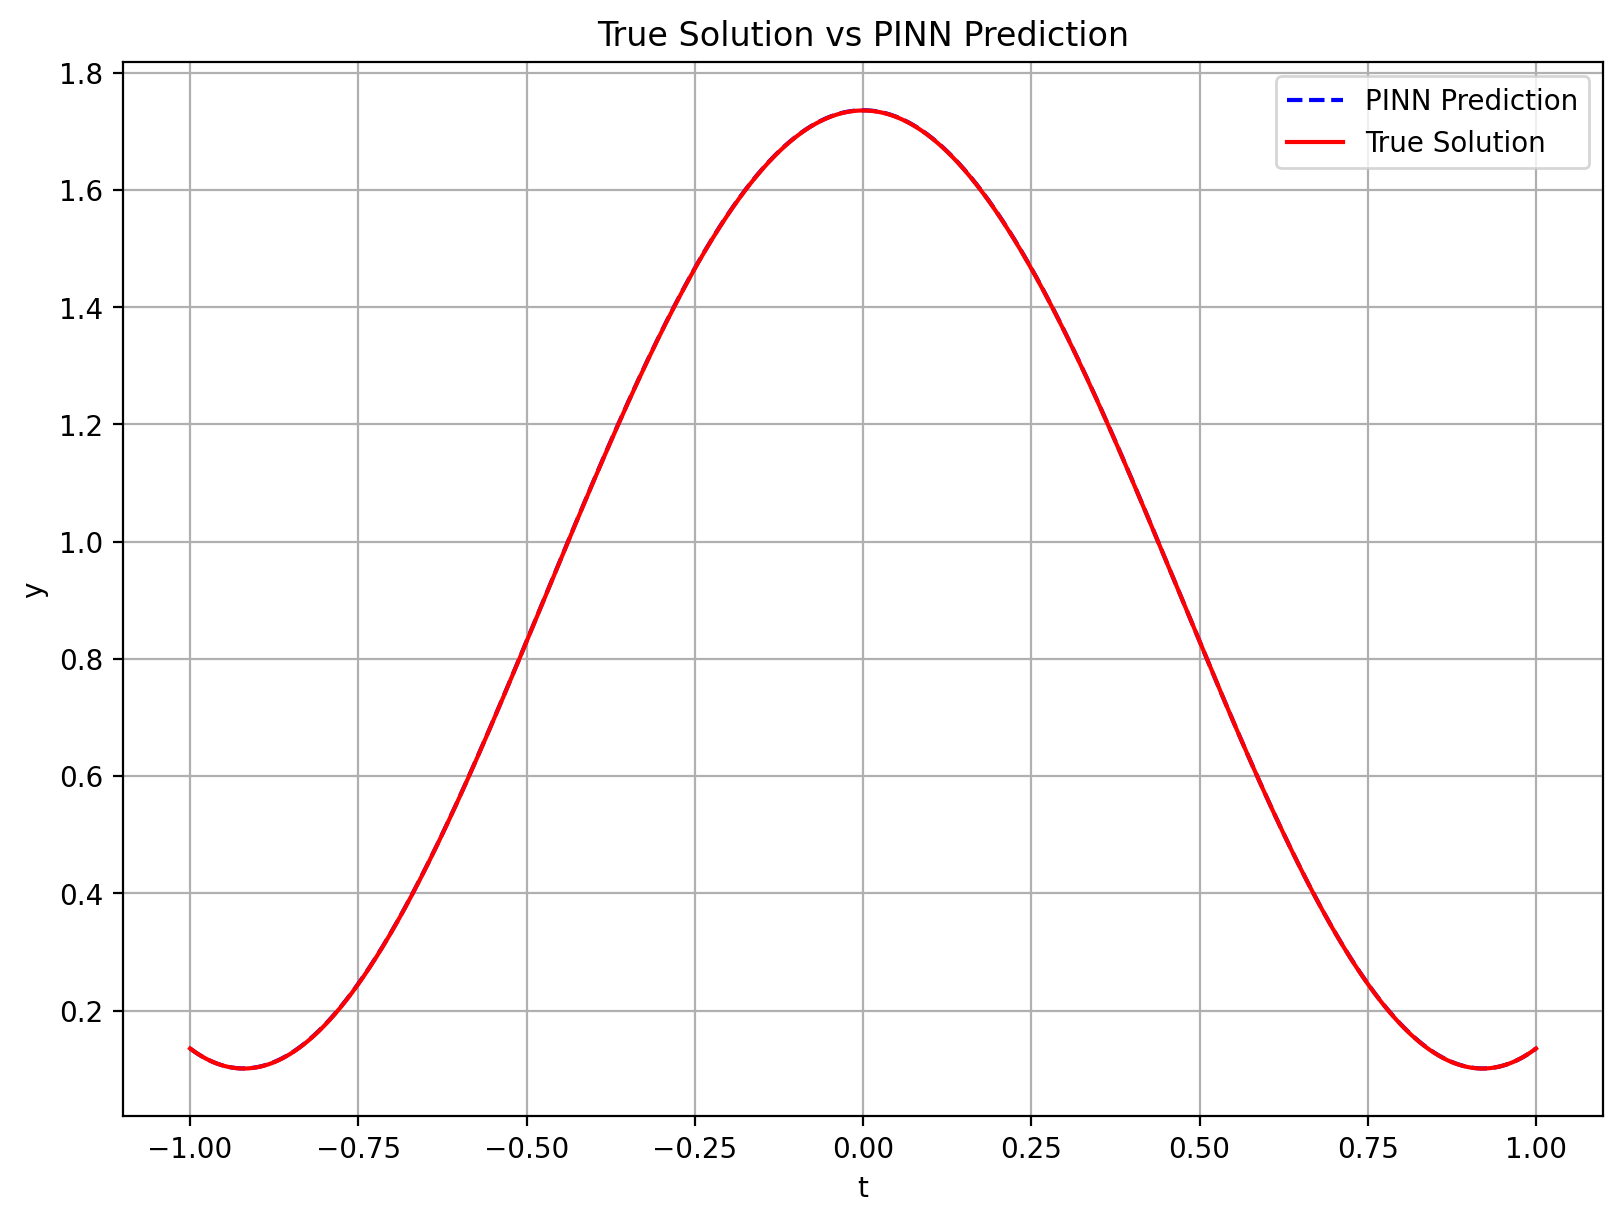

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model and other components are already defined and trained...

# Define a function to get the model's prediction
def pinn_prediction(model, t, eps):
    # Use the trained model to compute y
    with torch.no_grad():  # We don't need gradients when predicting
      # Ensure eps is converted to a PyTorch tensor

      # Use the corrected eps_tensor for torch operations
      y_pred =  -(t - 1) * (1 + t) * model(t) + np.exp(-2 / np.sqrt(eps))
      return y_pred

# True solution function based on your formulation
def true_solution(t, eps):
    return torch.cos(np.pi * t) + torch.exp((t - 1) / np.sqrt(eps)) + torch.exp(-(t + 1) / np.sqrt(eps))

# Create a grid of points for the domain
t_values = torch.linspace(domain[0], domain[1], 5000).view(-1, 1)  # 500 points for smooth curve

# Compute the model's prediction (PINN)
y_pred = pinn_prediction(model, t_values, eps)

# Compute the true solution
y_true = true_solution(t_values, eps)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(t_values, y_pred, label='PINN Prediction', color='blue', linestyle='--')
plt.plot(t_values, y_true, label='True Solution', color='red')
plt.xlabel('t')
plt.ylabel('y')
plt.title('True Solution vs PINN Prediction')
plt.legend()
plt.grid(True)
plt.show()


## Number 2 Error Table

In [ ]:
# Initialize data arrays
DATA1 = []
DATA2 = []
RATI7 = []


# Initialize data arrays
epsilons = [1.0e-5,1.0e-7, 1.0e-8, 1.0e-9, 1.0e-10]  # Example epsilon values 1.0e-2,1.0e-3,1.0e-4,
neuron_counts = [20, 40, 80, 160, 320]  # Example neuron counts


max_errors = np.zeros((len(epsilons), len(neuron_counts)))  # 2D array for storing errors

domain = (-1, 1)

# Function to compute gradients
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

# Loop over each epsilon value
for i, eps in enumerate(epsilons):

    # Loop over each neuron count
    for j, n in enumerate(neuron_counts):
        torch.manual_seed(78)  # For reproducibility
        model = MLP(1, n, n, n, 1)  # Change the number of neurons
        batch_size = 10000
        n_epochs = 500
        learning_rate = 0.001

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch)

        # Train the model
        for epoch in tqdm(range(n_epochs)):
            optimizer.zero_grad()

            # Generate random t and compute y_e
            t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
            y_e = torch.cos(np.pi * t) + torch.exp((t - 1) / np.sqrt(eps)) + torch.exp(-(t + 1) / np.sqrt(eps))

            # Neural network output and its derivatives
            y = (1 - t) * (1 + t) * model(t) + np.exp(-2 / np.sqrt(eps))
            y_t = grad(y, t)
            y_tt = grad(y_t, t)
            y_ttt = grad(y_tt, t)

            # Loss calculations
            loss_de = torch.max(torch.abs(eps * y_tt - y + (eps * (np.pi ** 2) + 1) * torch.cos(np.pi * t)))
            # + \ torch.max(torch.abs(eps * y_ttt - y_t - np.pi * (eps * (np.pi ** 2) + 1) * torch.sin(np.pi * t))) # for GPINN
            loss = loss_de
            realloss = torch.max(torch.abs(y - y_e))

            # Backpropagation
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Record the maximum error for the last epoch
            if epoch == n_epochs - 1:
                max_errors[i, j] = realloss.item()  # Store the error in the correct position

# Print the table of errors
print("Table: Maximum Errors for Different Values of ε and n")
print("| ε           | n = 20       | n = 40       | n = 80       | n =160       | n =320       | n =640       |")
print("|-------------|--------------|--------------|--------------|--------------|--------------|--------------|")

# Loop to print the results in table format
for i, epsilon in enumerate(epsilons):
    row = f"| {epsilon:<11} |"
    for j, n in enumerate(neuron_counts):
        row += f" {max_errors[i, j]:<12.2E} |"
    print(row)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Table: Maximum Errors for Different Values of ε and n
| ε           | n = 20       | n = 40       | n = 80       | n =160       | n =320       | n =640       |
|-------------|--------------|--------------|--------------|--------------|--------------|--------------|
| 1e-05       | 9.99E-01     | 9.97E-01     | 9.97E-01     | 9.96E-01     | 9.92E-01     |
| 1e-07       | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     | 9.99E-01     |
| 1e-08       | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     |
| 1e-09       | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     |
| 1e-10       | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     | 1.00E+00     |


# Various values of Epsilon

In [4]:
import numpy as np
Eps=np.arange(0.04,1,0.01)
Eps


domain = (-1, 1)


In [10]:
DATA91=[]
DATA92=[]
RATIO9=[]


# import numpy as np
# Eps=np.array([1.0,1.0e-4,1.0e-5, 1.0e-8, 1.0e-9, 1.0e-10])
# Eps

for eps in Eps:
    torch.manual_seed(78)
    model = MLP(1,50,50,1)
    batch_size = 10000
    n_epochs = 500
    print_interval = n_epochs // 10
    learning_rate = 0.1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                            lr_lambda=lambda epoch: 0.98 ** epoch,
                                            last_epoch=-1,
                                            verbose=False)

    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
        y= (1 - t) * (1 + t) * model(t) + np.exp(-2 / np.sqrt(eps))
        y_e = torch.cos(np.pi * t) + torch.exp((t - 1) / np.sqrt(eps)) +  torch.exp(-(t + 1) / np.sqrt(eps))
        y_t = grad(y, t)
        y_tt = grad(y_t,t)

        # Loss
        loss_de = F.mse_loss(eps* y_tt - y + (eps* (np.pi ** 2) + 1) * torch.cos(np.pi * t), torch.zeros_like(y_t))
        loss = loss_de
        realloss=F.mse_loss(y-y_e, torch.zeros_like(y))
        # Backprop
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % print_interval == 0:
            print(f"{epoch = }, loss_de = {loss_de.item():.4f}")
        if epoch==n_epochs-1:
            print(realloss.item())
            DATA91.append(realloss.item())
            DATA92.append(loss.item())
            RATIO9.append(realloss.item()/loss.item())


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 0.8431
epoch = 50, loss_de = 0.0095
epoch = 100, loss_de = 0.0008
epoch = 150, loss_de = 0.0007
epoch = 200, loss_de = 0.0006
epoch = 250, loss_de = 0.0006
epoch = 300, loss_de = 0.0006
epoch = 350, loss_de = 0.0006
epoch = 400, loss_de = 0.0006
epoch = 450, loss_de = 0.0006
2.2352890027832473e-06


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 0.9731
epoch = 50, loss_de = 0.0043
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
3.3619278383412166e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.1130
epoch = 50, loss_de = 0.0050
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0003
epoch = 300, loss_de = 0.0003
epoch = 350, loss_de = 0.0003
epoch = 400, loss_de = 0.0003
epoch = 450, loss_de = 0.0003
2.839107082763803e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.2627
epoch = 50, loss_de = 0.0043
epoch = 100, loss_de = 0.0003
epoch = 150, loss_de = 0.0002
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
1.118206185424242e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.4223
epoch = 50, loss_de = 0.0007
epoch = 100, loss_de = 0.0001
epoch = 150, loss_de = 0.0001
epoch = 200, loss_de = 0.0001
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
6.239605454538832e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.5917
epoch = 50, loss_de = 0.0018
epoch = 100, loss_de = 0.0001
epoch = 150, loss_de = 0.0000
epoch = 200, loss_de = 0.0000
epoch = 250, loss_de = 0.0000
epoch = 300, loss_de = 0.0000
epoch = 350, loss_de = 0.0000
epoch = 400, loss_de = 0.0000
epoch = 450, loss_de = 0.0000
1.0386054682953727e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.7710
epoch = 50, loss_de = 0.0030
epoch = 100, loss_de = 0.0001
epoch = 150, loss_de = 0.0001
epoch = 200, loss_de = 0.0001
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
4.269286080216261e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.9602
epoch = 50, loss_de = 0.0021
epoch = 100, loss_de = 0.0001
epoch = 150, loss_de = 0.0000
epoch = 200, loss_de = 0.0000
epoch = 250, loss_de = 0.0000
epoch = 300, loss_de = 0.0000
epoch = 350, loss_de = 0.0000
epoch = 400, loss_de = 0.0000
epoch = 450, loss_de = 0.0000
2.3312999530844536e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 2.1593
epoch = 50, loss_de = 0.0024
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
1.0234624170379902e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 2.3682
epoch = 50, loss_de = 0.0041
epoch = 100, loss_de = 0.0002
epoch = 150, loss_de = 0.0002
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
5.8975164307639716e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 2.5870
epoch = 50, loss_de = 0.0021
epoch = 100, loss_de = 0.0001
epoch = 150, loss_de = 0.0001
epoch = 200, loss_de = 0.0001
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
1.1662913301790923e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 2.8157
epoch = 50, loss_de = 0.0035
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
7.100904753087889e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 3.0542
epoch = 50, loss_de = 0.0047
epoch = 100, loss_de = 0.0002
epoch = 150, loss_de = 0.0001
epoch = 200, loss_de = 0.0001
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
2.5407539183675e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 3.3027
epoch = 50, loss_de = 0.0032
epoch = 100, loss_de = 0.0002
epoch = 150, loss_de = 0.0002
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
1.8789302558275267e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 3.5610
epoch = 50, loss_de = 0.0080
epoch = 100, loss_de = 0.0002
epoch = 150, loss_de = 0.0001
epoch = 200, loss_de = 0.0001
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
1.4742734144590486e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 3.8292
epoch = 50, loss_de = 0.0035
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0003
epoch = 300, loss_de = 0.0003
epoch = 350, loss_de = 0.0003
epoch = 400, loss_de = 0.0003
epoch = 450, loss_de = 0.0003
6.49106013383971e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 4.1072
epoch = 50, loss_de = 0.0100
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0003
epoch = 300, loss_de = 0.0003
epoch = 350, loss_de = 0.0003
epoch = 400, loss_de = 0.0003
epoch = 450, loss_de = 0.0003
8.072764501321217e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 4.3952
epoch = 50, loss_de = 0.0086
epoch = 100, loss_de = 0.0010
epoch = 150, loss_de = 0.0006
epoch = 200, loss_de = 0.0005
epoch = 250, loss_de = 0.0005
epoch = 300, loss_de = 0.0005
epoch = 350, loss_de = 0.0005
epoch = 400, loss_de = 0.0005
epoch = 450, loss_de = 0.0005
2.156226912575221e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 4.6930
epoch = 50, loss_de = 0.0058
epoch = 100, loss_de = 0.0003
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
4.222090410621604e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 5.0007
epoch = 50, loss_de = 0.0137
epoch = 100, loss_de = 0.0008
epoch = 150, loss_de = 0.0006
epoch = 200, loss_de = 0.0005
epoch = 250, loss_de = 0.0005
epoch = 300, loss_de = 0.0005
epoch = 350, loss_de = 0.0005
epoch = 400, loss_de = 0.0005
epoch = 450, loss_de = 0.0005
1.170744852174721e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 5.3182
epoch = 50, loss_de = 0.0112
epoch = 100, loss_de = 0.0010
epoch = 150, loss_de = 0.0007
epoch = 200, loss_de = 0.0006
epoch = 250, loss_de = 0.0005
epoch = 300, loss_de = 0.0005
epoch = 350, loss_de = 0.0005
epoch = 400, loss_de = 0.0005
epoch = 450, loss_de = 0.0005
3.564104531506018e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 5.6456
epoch = 50, loss_de = 0.0115
epoch = 100, loss_de = 0.0016
epoch = 150, loss_de = 0.0013
epoch = 200, loss_de = 0.0011
epoch = 250, loss_de = 0.0011
epoch = 300, loss_de = 0.0011
epoch = 350, loss_de = 0.0011
epoch = 400, loss_de = 0.0011
epoch = 450, loss_de = 0.0011
3.5728527336686966e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 5.9829
epoch = 50, loss_de = 0.0110
epoch = 100, loss_de = 0.0009
epoch = 150, loss_de = 0.0005
epoch = 200, loss_de = 0.0005
epoch = 250, loss_de = 0.0004
epoch = 300, loss_de = 0.0004
epoch = 350, loss_de = 0.0004
epoch = 400, loss_de = 0.0004
epoch = 450, loss_de = 0.0004
1.6755535625634366e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 6.3300
epoch = 50, loss_de = 0.0060
epoch = 100, loss_de = 0.0001
epoch = 150, loss_de = 0.0001
epoch = 200, loss_de = 0.0001
epoch = 250, loss_de = 0.0001
epoch = 300, loss_de = 0.0001
epoch = 350, loss_de = 0.0001
epoch = 400, loss_de = 0.0001
epoch = 450, loss_de = 0.0001
1.5901440164611813e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 6.6870
epoch = 50, loss_de = 0.0113
epoch = 100, loss_de = 0.0009
epoch = 150, loss_de = 0.0007
epoch = 200, loss_de = 0.0007
epoch = 250, loss_de = 0.0007
epoch = 300, loss_de = 0.0007
epoch = 350, loss_de = 0.0007
epoch = 400, loss_de = 0.0007
epoch = 450, loss_de = 0.0007
9.49564764596289e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 7.0539
epoch = 50, loss_de = 0.0071
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0003
epoch = 300, loss_de = 0.0003
epoch = 350, loss_de = 0.0003
epoch = 400, loss_de = 0.0003
epoch = 450, loss_de = 0.0003
3.6020416871451744e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 7.4306
epoch = 50, loss_de = 0.0270
epoch = 100, loss_de = 0.0003
epoch = 150, loss_de = 0.0002
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
1.9270080642286302e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 7.8172
epoch = 50, loss_de = 0.0213
epoch = 100, loss_de = 0.0015
epoch = 150, loss_de = 0.0010
epoch = 200, loss_de = 0.0009
epoch = 250, loss_de = 0.0008
epoch = 300, loss_de = 0.0008
epoch = 350, loss_de = 0.0008
epoch = 400, loss_de = 0.0008
epoch = 450, loss_de = 0.0008
2.497772584320046e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 8.2137
epoch = 50, loss_de = 0.0136
epoch = 100, loss_de = 0.0010
epoch = 150, loss_de = 0.0008
epoch = 200, loss_de = 0.0007
epoch = 250, loss_de = 0.0007
epoch = 300, loss_de = 0.0007
epoch = 350, loss_de = 0.0007
epoch = 400, loss_de = 0.0007
epoch = 450, loss_de = 0.0007
6.192756529799226e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 8.6200
epoch = 50, loss_de = 0.0183
epoch = 100, loss_de = 0.0013
epoch = 150, loss_de = 0.0011
epoch = 200, loss_de = 0.0010
epoch = 250, loss_de = 0.0010
epoch = 300, loss_de = 0.0010
epoch = 350, loss_de = 0.0010
epoch = 400, loss_de = 0.0010
epoch = 450, loss_de = 0.0010
5.9243269845410396e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 9.0362
epoch = 50, loss_de = 0.0141
epoch = 100, loss_de = 0.0010
epoch = 150, loss_de = 0.0007
epoch = 200, loss_de = 0.0006
epoch = 250, loss_de = 0.0005
epoch = 300, loss_de = 0.0005
epoch = 350, loss_de = 0.0005
epoch = 400, loss_de = 0.0005
epoch = 450, loss_de = 0.0005
2.6931360253001912e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 9.4622
epoch = 50, loss_de = 0.0126
epoch = 100, loss_de = 0.0010
epoch = 150, loss_de = 0.0008
epoch = 200, loss_de = 0.0007
epoch = 250, loss_de = 0.0007
epoch = 300, loss_de = 0.0007
epoch = 350, loss_de = 0.0007
epoch = 400, loss_de = 0.0007
epoch = 450, loss_de = 0.0007
8.48989927249022e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 9.8981
epoch = 50, loss_de = 0.0082
epoch = 100, loss_de = 0.0009
epoch = 150, loss_de = 0.0007
epoch = 200, loss_de = 0.0006
epoch = 250, loss_de = 0.0006
epoch = 300, loss_de = 0.0006
epoch = 350, loss_de = 0.0006
epoch = 400, loss_de = 0.0006
epoch = 450, loss_de = 0.0006
7.872409923947998e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 10.3438
epoch = 50, loss_de = 0.0120
epoch = 100, loss_de = 0.0011
epoch = 150, loss_de = 0.0008
epoch = 200, loss_de = 0.0007
epoch = 250, loss_de = 0.0007
epoch = 300, loss_de = 0.0007
epoch = 350, loss_de = 0.0007
epoch = 400, loss_de = 0.0006
epoch = 450, loss_de = 0.0007
4.374582829314022e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 10.7994
epoch = 50, loss_de = 0.0243
epoch = 100, loss_de = 0.0014
epoch = 150, loss_de = 0.0011
epoch = 200, loss_de = 0.0010
epoch = 250, loss_de = 0.0010
epoch = 300, loss_de = 0.0011
epoch = 350, loss_de = 0.0011
epoch = 400, loss_de = 0.0010
epoch = 450, loss_de = 0.0010
1.2739218391288887e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 11.2648
epoch = 50, loss_de = 0.0121
epoch = 100, loss_de = 0.0010
epoch = 150, loss_de = 0.0008
epoch = 200, loss_de = 0.0007
epoch = 250, loss_de = 0.0007
epoch = 300, loss_de = 0.0007
epoch = 350, loss_de = 0.0007
epoch = 400, loss_de = 0.0007
epoch = 450, loss_de = 0.0007
5.650676371260488e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 11.7401
epoch = 50, loss_de = 0.0312
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0002
epoch = 200, loss_de = 0.0002
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
4.783403895203264e-09


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 12.2253
epoch = 50, loss_de = 0.0143
epoch = 100, loss_de = 0.0005
epoch = 150, loss_de = 0.0004
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0003
epoch = 300, loss_de = 0.0003
epoch = 350, loss_de = 0.0003
epoch = 400, loss_de = 0.0003
epoch = 450, loss_de = 0.0003
4.4342152172305305e-09


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 12.7203
epoch = 50, loss_de = 0.0166
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
4.754529214778813e-09


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 13.2251
epoch = 50, loss_de = 0.0106
epoch = 100, loss_de = 0.0004
epoch = 150, loss_de = 0.0003
epoch = 200, loss_de = 0.0003
epoch = 250, loss_de = 0.0002
epoch = 300, loss_de = 0.0002
epoch = 350, loss_de = 0.0002
epoch = 400, loss_de = 0.0002
epoch = 450, loss_de = 0.0002
4.309325341012027e-09


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 13.7398
epoch = 50, loss_de = 0.0136
epoch = 100, loss_de = 0.0015
epoch = 150, loss_de = 0.0013
epoch = 200, loss_de = 0.0012
epoch = 250, loss_de = 0.0012
epoch = 300, loss_de = 0.0011
epoch = 350, loss_de = 0.0012
epoch = 400, loss_de = 0.0012
epoch = 450, loss_de = 0.0011
2.0083270158011146e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 14.2643
epoch = 50, loss_de = 0.0220
epoch = 100, loss_de = 0.0016
epoch = 150, loss_de = 0.0012
epoch = 200, loss_de = 0.0011
epoch = 250, loss_de = 0.0010
epoch = 300, loss_de = 0.0010
epoch = 350, loss_de = 0.0010
epoch = 400, loss_de = 0.0010
epoch = 450, loss_de = 0.0010
1.8730101913888575e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 14.7987
epoch = 50, loss_de = 0.0212
epoch = 100, loss_de = 0.0009
epoch = 150, loss_de = 0.0008
epoch = 200, loss_de = 0.0008
epoch = 250, loss_de = 0.0008
epoch = 300, loss_de = 0.0008
epoch = 350, loss_de = 0.0008
epoch = 400, loss_de = 0.0007
epoch = 450, loss_de = 0.0008
8.499945636231132e-09


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 15.3429
epoch = 50, loss_de = 0.0366
epoch = 100, loss_de = 0.0017
epoch = 150, loss_de = 0.0013
epoch = 200, loss_de = 0.0012
epoch = 250, loss_de = 0.0011
epoch = 300, loss_de = 0.0012
epoch = 350, loss_de = 0.0011
epoch = 400, loss_de = 0.0011
epoch = 450, loss_de = 0.0012
1.781381797627546e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 15.8970
epoch = 50, loss_de = 0.0368
epoch = 100, loss_de = 0.0014
epoch = 150, loss_de = 0.0010
epoch = 200, loss_de = 0.0009
epoch = 250, loss_de = 0.0008
epoch = 300, loss_de = 0.0009
epoch = 350, loss_de = 0.0009
epoch = 400, loss_de = 0.0008
epoch = 450, loss_de = 0.0009
2.1506320280195723e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 16.4609
epoch = 50, loss_de = 0.0311
epoch = 100, loss_de = 0.0014
epoch = 150, loss_de = 0.0009
epoch = 200, loss_de = 0.0008
epoch = 250, loss_de = 0.0007
epoch = 300, loss_de = 0.0008
epoch = 350, loss_de = 0.0007
epoch = 400, loss_de = 0.0007
epoch = 450, loss_de = 0.0007
3.684416682858682e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 17.0346
epoch = 50, loss_de = 0.0313
epoch = 100, loss_de = 0.0032
epoch = 150, loss_de = 0.0026
epoch = 200, loss_de = 0.0023
epoch = 250, loss_de = 0.0023
epoch = 300, loss_de = 0.0023
epoch = 350, loss_de = 0.0023
epoch = 400, loss_de = 0.0022
epoch = 450, loss_de = 0.0022
4.055453928231145e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 17.6182
epoch = 50, loss_de = 0.0344
epoch = 100, loss_de = 0.0035
epoch = 150, loss_de = 0.0025
epoch = 200, loss_de = 0.0022
epoch = 250, loss_de = 0.0020
epoch = 300, loss_de = 0.0021
epoch = 350, loss_de = 0.0020
epoch = 400, loss_de = 0.0021
epoch = 450, loss_de = 0.0020
2.2679401467939897e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 18.2117
epoch = 50, loss_de = 0.0766
epoch = 100, loss_de = 0.0022
epoch = 150, loss_de = 0.0012
epoch = 200, loss_de = 0.0010
epoch = 250, loss_de = 0.0010
epoch = 300, loss_de = 0.0009
epoch = 350, loss_de = 0.0009
epoch = 400, loss_de = 0.0009
epoch = 450, loss_de = 0.0009
5.47091119074139e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 18.8149
epoch = 50, loss_de = 0.0716
epoch = 100, loss_de = 0.0023
epoch = 150, loss_de = 0.0015
epoch = 200, loss_de = 0.0013
epoch = 250, loss_de = 0.0013
epoch = 300, loss_de = 0.0014
epoch = 350, loss_de = 0.0013
epoch = 400, loss_de = 0.0012
epoch = 450, loss_de = 0.0013
1.2927260684136854e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 19.4280
epoch = 50, loss_de = 0.0815
epoch = 100, loss_de = 0.0039
epoch = 150, loss_de = 0.0026
epoch = 200, loss_de = 0.0024
epoch = 250, loss_de = 0.0023
epoch = 300, loss_de = 0.0023
epoch = 350, loss_de = 0.0023
epoch = 400, loss_de = 0.0023
epoch = 450, loss_de = 0.0023
1.1660413434810835e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 20.0510
epoch = 50, loss_de = 0.0828
epoch = 100, loss_de = 0.0036
epoch = 150, loss_de = 0.0028
epoch = 200, loss_de = 0.0025
epoch = 250, loss_de = 0.0024
epoch = 300, loss_de = 0.0025
epoch = 350, loss_de = 0.0024
epoch = 400, loss_de = 0.0024
epoch = 450, loss_de = 0.0024
5.818209558583476e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 20.6838
epoch = 50, loss_de = 0.0482
epoch = 100, loss_de = 0.0056
epoch = 150, loss_de = 0.0040
epoch = 200, loss_de = 0.0037
epoch = 250, loss_de = 0.0035
epoch = 300, loss_de = 0.0035
epoch = 350, loss_de = 0.0034
epoch = 400, loss_de = 0.0033
epoch = 450, loss_de = 0.0034
1.1855347281652939e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 21.3264
epoch = 50, loss_de = 0.0773
epoch = 100, loss_de = 0.0060
epoch = 150, loss_de = 0.0046
epoch = 200, loss_de = 0.0040
epoch = 250, loss_de = 0.0039
epoch = 300, loss_de = 0.0041
epoch = 350, loss_de = 0.0040
epoch = 400, loss_de = 0.0038
epoch = 450, loss_de = 0.0040
4.3408576289039047e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 21.9789
epoch = 50, loss_de = 0.0354
epoch = 100, loss_de = 0.0044
epoch = 150, loss_de = 0.0032
epoch = 200, loss_de = 0.0030
epoch = 250, loss_de = 0.0028
epoch = 300, loss_de = 0.0028
epoch = 350, loss_de = 0.0028
epoch = 400, loss_de = 0.0028
epoch = 450, loss_de = 0.0028
9.591747129888972e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 22.6412
epoch = 50, loss_de = 0.0289
epoch = 100, loss_de = 0.0023
epoch = 150, loss_de = 0.0018
epoch = 200, loss_de = 0.0016
epoch = 250, loss_de = 0.0015
epoch = 300, loss_de = 0.0016
epoch = 350, loss_de = 0.0016
epoch = 400, loss_de = 0.0015
epoch = 450, loss_de = 0.0015
1.0117246773688748e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 23.3133
epoch = 50, loss_de = 0.0411
epoch = 100, loss_de = 0.0074
epoch = 150, loss_de = 0.0058
epoch = 200, loss_de = 0.0053
epoch = 250, loss_de = 0.0051
epoch = 300, loss_de = 0.0051
epoch = 350, loss_de = 0.0051
epoch = 400, loss_de = 0.0049
epoch = 450, loss_de = 0.0051
2.466225623720675e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 23.9953
epoch = 50, loss_de = 0.0686
epoch = 100, loss_de = 0.0029
epoch = 150, loss_de = 0.0025
epoch = 200, loss_de = 0.0024
epoch = 250, loss_de = 0.0024
epoch = 300, loss_de = 0.0025
epoch = 350, loss_de = 0.0025
epoch = 400, loss_de = 0.0023
epoch = 450, loss_de = 0.0025
3.354373063757521e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 24.6871
epoch = 50, loss_de = 0.1564
epoch = 100, loss_de = 0.0074
epoch = 150, loss_de = 0.0061
epoch = 200, loss_de = 0.0057
epoch = 250, loss_de = 0.0056
epoch = 300, loss_de = 0.0057
epoch = 350, loss_de = 0.0058
epoch = 400, loss_de = 0.0056
epoch = 450, loss_de = 0.0057
8.651121561342734e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 25.3887
epoch = 50, loss_de = 0.0606
epoch = 100, loss_de = 0.0045
epoch = 150, loss_de = 0.0030
epoch = 200, loss_de = 0.0026
epoch = 250, loss_de = 0.0024
epoch = 300, loss_de = 0.0025
epoch = 350, loss_de = 0.0024
epoch = 400, loss_de = 0.0023
epoch = 450, loss_de = 0.0025
1.2663778647947765e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 26.1002
epoch = 50, loss_de = 0.1233
epoch = 100, loss_de = 0.0111
epoch = 150, loss_de = 0.0079
epoch = 200, loss_de = 0.0071
epoch = 250, loss_de = 0.0065
epoch = 300, loss_de = 0.0068
epoch = 350, loss_de = 0.0065
epoch = 400, loss_de = 0.0066
epoch = 450, loss_de = 0.0064
1.4402789929590654e-06


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 26.8215
epoch = 50, loss_de = 0.3066
epoch = 100, loss_de = 0.0776
epoch = 150, loss_de = 0.0612
epoch = 200, loss_de = 0.0523
epoch = 250, loss_de = 0.0531
epoch = 300, loss_de = 0.0540
epoch = 350, loss_de = 0.0530
epoch = 400, loss_de = 0.0509
epoch = 450, loss_de = 0.0538
7.0812544436194e-05


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 27.5526
epoch = 50, loss_de = 0.7853
epoch = 100, loss_de = 0.1489
epoch = 150, loss_de = 0.1185
epoch = 200, loss_de = 0.1031
epoch = 250, loss_de = 0.1032
epoch = 300, loss_de = 0.1062
epoch = 350, loss_de = 0.1032
epoch = 400, loss_de = 0.1007
epoch = 450, loss_de = 0.1051
0.00018551225366536528


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 28.2936
epoch = 50, loss_de = 0.4880
epoch = 100, loss_de = 0.0911
epoch = 150, loss_de = 0.0713
epoch = 200, loss_de = 0.0625
epoch = 250, loss_de = 0.0622
epoch = 300, loss_de = 0.0632
epoch = 350, loss_de = 0.0622
epoch = 400, loss_de = 0.0596
epoch = 450, loss_de = 0.0634
6.86523926560767e-05


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 29.0444
epoch = 50, loss_de = 0.0796
epoch = 100, loss_de = 0.0008
epoch = 150, loss_de = 0.0004
epoch = 200, loss_de = 0.0004
epoch = 250, loss_de = 0.0003
epoch = 300, loss_de = 0.0003
epoch = 350, loss_de = 0.0003
epoch = 400, loss_de = 0.0003
epoch = 450, loss_de = 0.0003
1.0025342334074594e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 29.8050
epoch = 50, loss_de = 0.0262
epoch = 100, loss_de = 0.0016
epoch = 150, loss_de = 0.0011
epoch = 200, loss_de = 0.0010
epoch = 250, loss_de = 0.0009
epoch = 300, loss_de = 0.0010
epoch = 350, loss_de = 0.0009
epoch = 400, loss_de = 0.0009
epoch = 450, loss_de = 0.0009
2.177022473404122e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 30.5755
epoch = 50, loss_de = 0.0507
epoch = 100, loss_de = 0.0029
epoch = 150, loss_de = 0.0022
epoch = 200, loss_de = 0.0020
epoch = 250, loss_de = 0.0019
epoch = 300, loss_de = 0.0019
epoch = 350, loss_de = 0.0019
epoch = 400, loss_de = 0.0019
epoch = 450, loss_de = 0.0019
3.737763520916815e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 31.3558
epoch = 50, loss_de = 0.0385
epoch = 100, loss_de = 0.0058
epoch = 150, loss_de = 0.0040
epoch = 200, loss_de = 0.0036
epoch = 250, loss_de = 0.0033
epoch = 300, loss_de = 0.0033
epoch = 350, loss_de = 0.0032
epoch = 400, loss_de = 0.0033
epoch = 450, loss_de = 0.0032
1.2780719771399163e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 32.1459
epoch = 50, loss_de = 0.0507
epoch = 100, loss_de = 0.0039
epoch = 150, loss_de = 0.0030
epoch = 200, loss_de = 0.0027
epoch = 250, loss_de = 0.0026
epoch = 300, loss_de = 0.0026
epoch = 350, loss_de = 0.0025
epoch = 400, loss_de = 0.0026
epoch = 450, loss_de = 0.0025
4.724087432350643e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 32.9458
epoch = 50, loss_de = 0.0645
epoch = 100, loss_de = 0.0041
epoch = 150, loss_de = 0.0029
epoch = 200, loss_de = 0.0025
epoch = 250, loss_de = 0.0025
epoch = 300, loss_de = 0.0024
epoch = 350, loss_de = 0.0024
epoch = 400, loss_de = 0.0025
epoch = 450, loss_de = 0.0023
7.133440504958344e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 33.7556
epoch = 50, loss_de = 0.0523
epoch = 100, loss_de = 0.0027
epoch = 150, loss_de = 0.0020
epoch = 200, loss_de = 0.0018
epoch = 250, loss_de = 0.0017
epoch = 300, loss_de = 0.0018
epoch = 350, loss_de = 0.0017
epoch = 400, loss_de = 0.0017
epoch = 450, loss_de = 0.0017
3.034854145766985e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 34.5752
epoch = 50, loss_de = 0.0566
epoch = 100, loss_de = 0.0021
epoch = 150, loss_de = 0.0014
epoch = 200, loss_de = 0.0012
epoch = 250, loss_de = 0.0012
epoch = 300, loss_de = 0.0012
epoch = 350, loss_de = 0.0012
epoch = 400, loss_de = 0.0012
epoch = 450, loss_de = 0.0012
2.3563661244452305e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 35.4046
epoch = 50, loss_de = 0.0715
epoch = 100, loss_de = 0.0062
epoch = 150, loss_de = 0.0037
epoch = 200, loss_de = 0.0030
epoch = 250, loss_de = 0.0027
epoch = 300, loss_de = 0.0028
epoch = 350, loss_de = 0.0027
epoch = 400, loss_de = 0.0027
epoch = 450, loss_de = 0.0027
2.2853400594158302e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 36.2439
epoch = 50, loss_de = 0.0996
epoch = 100, loss_de = 0.0068
epoch = 150, loss_de = 0.0051
epoch = 200, loss_de = 0.0047
epoch = 250, loss_de = 0.0044
epoch = 300, loss_de = 0.0045
epoch = 350, loss_de = 0.0044
epoch = 400, loss_de = 0.0044
epoch = 450, loss_de = 0.0045
2.559113454481121e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 37.0930
epoch = 50, loss_de = 0.0949
epoch = 100, loss_de = 0.0022
epoch = 150, loss_de = 0.0014
epoch = 200, loss_de = 0.0012
epoch = 250, loss_de = 0.0011
epoch = 300, loss_de = 0.0011
epoch = 350, loss_de = 0.0011
epoch = 400, loss_de = 0.0011
epoch = 450, loss_de = 0.0011
1.4012705662480585e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 37.9519
epoch = 50, loss_de = 0.0634
epoch = 100, loss_de = 0.0018
epoch = 150, loss_de = 0.0012
epoch = 200, loss_de = 0.0011
epoch = 250, loss_de = 0.0010
epoch = 300, loss_de = 0.0010
epoch = 350, loss_de = 0.0010
epoch = 400, loss_de = 0.0010
epoch = 450, loss_de = 0.0010
2.5368033007566737e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 38.8206
epoch = 50, loss_de = 0.1103
epoch = 100, loss_de = 0.0061
epoch = 150, loss_de = 0.0039
epoch = 200, loss_de = 0.0034
epoch = 250, loss_de = 0.0032
epoch = 300, loss_de = 0.0032
epoch = 350, loss_de = 0.0031
epoch = 400, loss_de = 0.0030
epoch = 450, loss_de = 0.0031
4.637326966872024e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 39.6991
epoch = 50, loss_de = 0.1300
epoch = 100, loss_de = 0.0020
epoch = 150, loss_de = 0.0012
epoch = 200, loss_de = 0.0012
epoch = 250, loss_de = 0.0011
epoch = 300, loss_de = 0.0011
epoch = 350, loss_de = 0.0011
epoch = 400, loss_de = 0.0011
epoch = 450, loss_de = 0.0011
1.2277745042865718e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 40.5875
epoch = 50, loss_de = 0.1940
epoch = 100, loss_de = 0.0100
epoch = 150, loss_de = 0.0046
epoch = 200, loss_de = 0.0035
epoch = 250, loss_de = 0.0029
epoch = 300, loss_de = 0.0032
epoch = 350, loss_de = 0.0028
epoch = 400, loss_de = 0.0030
epoch = 450, loss_de = 0.0029
2.996394812271319e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 41.4857
epoch = 50, loss_de = 0.1271
epoch = 100, loss_de = 0.0045
epoch = 150, loss_de = 0.0034
epoch = 200, loss_de = 0.0032
epoch = 250, loss_de = 0.0029
epoch = 300, loss_de = 0.0031
epoch = 350, loss_de = 0.0029
epoch = 400, loss_de = 0.0030
epoch = 450, loss_de = 0.0029
1.464851493437891e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 42.3937
epoch = 50, loss_de = 0.0914
epoch = 100, loss_de = 0.0051
epoch = 150, loss_de = 0.0033
epoch = 200, loss_de = 0.0029
epoch = 250, loss_de = 0.0027
epoch = 300, loss_de = 0.0027
epoch = 350, loss_de = 0.0027
epoch = 400, loss_de = 0.0027
epoch = 450, loss_de = 0.0027
3.518190894169493e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 43.3116
epoch = 50, loss_de = 0.1516
epoch = 100, loss_de = 0.0059
epoch = 150, loss_de = 0.0049
epoch = 200, loss_de = 0.0046
epoch = 250, loss_de = 0.0045
epoch = 300, loss_de = 0.0047
epoch = 350, loss_de = 0.0045
epoch = 400, loss_de = 0.0045
epoch = 450, loss_de = 0.0045
1.2062091059306113e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 44.2393
epoch = 50, loss_de = 0.1131
epoch = 100, loss_de = 0.0026
epoch = 150, loss_de = 0.0018
epoch = 200, loss_de = 0.0017
epoch = 250, loss_de = 0.0016
epoch = 300, loss_de = 0.0017
epoch = 350, loss_de = 0.0015
epoch = 400, loss_de = 0.0016
epoch = 450, loss_de = 0.0016
3.3344690564263146e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 45.1768
epoch = 50, loss_de = 0.0762
epoch = 100, loss_de = 0.0038
epoch = 150, loss_de = 0.0028
epoch = 200, loss_de = 0.0025
epoch = 250, loss_de = 0.0024
epoch = 300, loss_de = 0.0024
epoch = 350, loss_de = 0.0024
epoch = 400, loss_de = 0.0024
epoch = 450, loss_de = 0.0024
4.427353772484821e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 46.1241
epoch = 50, loss_de = 0.1166
epoch = 100, loss_de = 0.0066
epoch = 150, loss_de = 0.0054
epoch = 200, loss_de = 0.0051
epoch = 250, loss_de = 0.0047
epoch = 300, loss_de = 0.0049
epoch = 350, loss_de = 0.0046
epoch = 400, loss_de = 0.0047
epoch = 450, loss_de = 0.0047
1.482802645114134e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 47.0812
epoch = 50, loss_de = 0.0686
epoch = 100, loss_de = 0.0054
epoch = 150, loss_de = 0.0038
epoch = 200, loss_de = 0.0034
epoch = 250, loss_de = 0.0031
epoch = 300, loss_de = 0.0033
epoch = 350, loss_de = 0.0031
epoch = 400, loss_de = 0.0031
epoch = 450, loss_de = 0.0031
4.7969297867211935e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 48.0482
epoch = 50, loss_de = 0.1030
epoch = 100, loss_de = 0.0136
epoch = 150, loss_de = 0.0103
epoch = 200, loss_de = 0.0094
epoch = 250, loss_de = 0.0092
epoch = 300, loss_de = 0.0092
epoch = 350, loss_de = 0.0093
epoch = 400, loss_de = 0.0088
epoch = 450, loss_de = 0.0092
2.9095613740537374e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 49.0250
epoch = 50, loss_de = 0.2386
epoch = 100, loss_de = 0.0070
epoch = 150, loss_de = 0.0043
epoch = 200, loss_de = 0.0040
epoch = 250, loss_de = 0.0038
epoch = 300, loss_de = 0.0038
epoch = 350, loss_de = 0.0037
epoch = 400, loss_de = 0.0037
epoch = 450, loss_de = 0.0037
1.1282457279548908e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 50.0116
epoch = 50, loss_de = 0.0854
epoch = 100, loss_de = 0.0032
epoch = 150, loss_de = 0.0024
epoch = 200, loss_de = 0.0022
epoch = 250, loss_de = 0.0021
epoch = 300, loss_de = 0.0022
epoch = 350, loss_de = 0.0021
epoch = 400, loss_de = 0.0021
epoch = 450, loss_de = 0.0021
2.81141172564503e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 51.0080
epoch = 50, loss_de = 0.1851
epoch = 100, loss_de = 0.0248
epoch = 150, loss_de = 0.0135
epoch = 200, loss_de = 0.0111
epoch = 250, loss_de = 0.0104
epoch = 300, loss_de = 0.0105
epoch = 350, loss_de = 0.0102
epoch = 400, loss_de = 0.0098
epoch = 450, loss_de = 0.0101
1.3765086350758793e-06


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 52.0142
epoch = 50, loss_de = 0.1546
epoch = 100, loss_de = 0.0039
epoch = 150, loss_de = 0.0024
epoch = 200, loss_de = 0.0022
epoch = 250, loss_de = 0.0021
epoch = 300, loss_de = 0.0021
epoch = 350, loss_de = 0.0021
epoch = 400, loss_de = 0.0021
epoch = 450, loss_de = 0.0021
3.1227845198600335e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 53.0303
epoch = 50, loss_de = 0.1425
epoch = 100, loss_de = 0.0025
epoch = 150, loss_de = 0.0016
epoch = 200, loss_de = 0.0015
epoch = 250, loss_de = 0.0014
epoch = 300, loss_de = 0.0014
epoch = 350, loss_de = 0.0014
epoch = 400, loss_de = 0.0014
epoch = 450, loss_de = 0.0014
4.074002646348163e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 54.0562
epoch = 50, loss_de = 0.0738
epoch = 100, loss_de = 0.0016
epoch = 150, loss_de = 0.0012
epoch = 200, loss_de = 0.0012
epoch = 250, loss_de = 0.0011
epoch = 300, loss_de = 0.0012
epoch = 350, loss_de = 0.0011
epoch = 400, loss_de = 0.0012
epoch = 450, loss_de = 0.0011
2.766990192526464e-08


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 55.0919
epoch = 50, loss_de = 0.1482
epoch = 100, loss_de = 0.0129
epoch = 150, loss_de = 0.0083
epoch = 200, loss_de = 0.0068
epoch = 250, loss_de = 0.0065
epoch = 300, loss_de = 0.0066
epoch = 350, loss_de = 0.0066
epoch = 400, loss_de = 0.0061
epoch = 450, loss_de = 0.0064
7.333096050388122e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 56.1374
epoch = 50, loss_de = 0.1698
epoch = 100, loss_de = 0.0137
epoch = 150, loss_de = 0.0102
epoch = 200, loss_de = 0.0091
epoch = 250, loss_de = 0.0089
epoch = 300, loss_de = 0.0089
epoch = 350, loss_de = 0.0090
epoch = 400, loss_de = 0.0086
epoch = 450, loss_de = 0.0088
8.802900310911355e-07


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 57.1927
epoch = 50, loss_de = 0.2451
epoch = 100, loss_de = 0.0038
epoch = 150, loss_de = 0.0028
epoch = 200, loss_de = 0.0026
epoch = 250, loss_de = 0.0025
epoch = 300, loss_de = 0.0026
epoch = 350, loss_de = 0.0025
epoch = 400, loss_de = 0.0025
epoch = 450, loss_de = 0.0025
1.052640641319158e-07


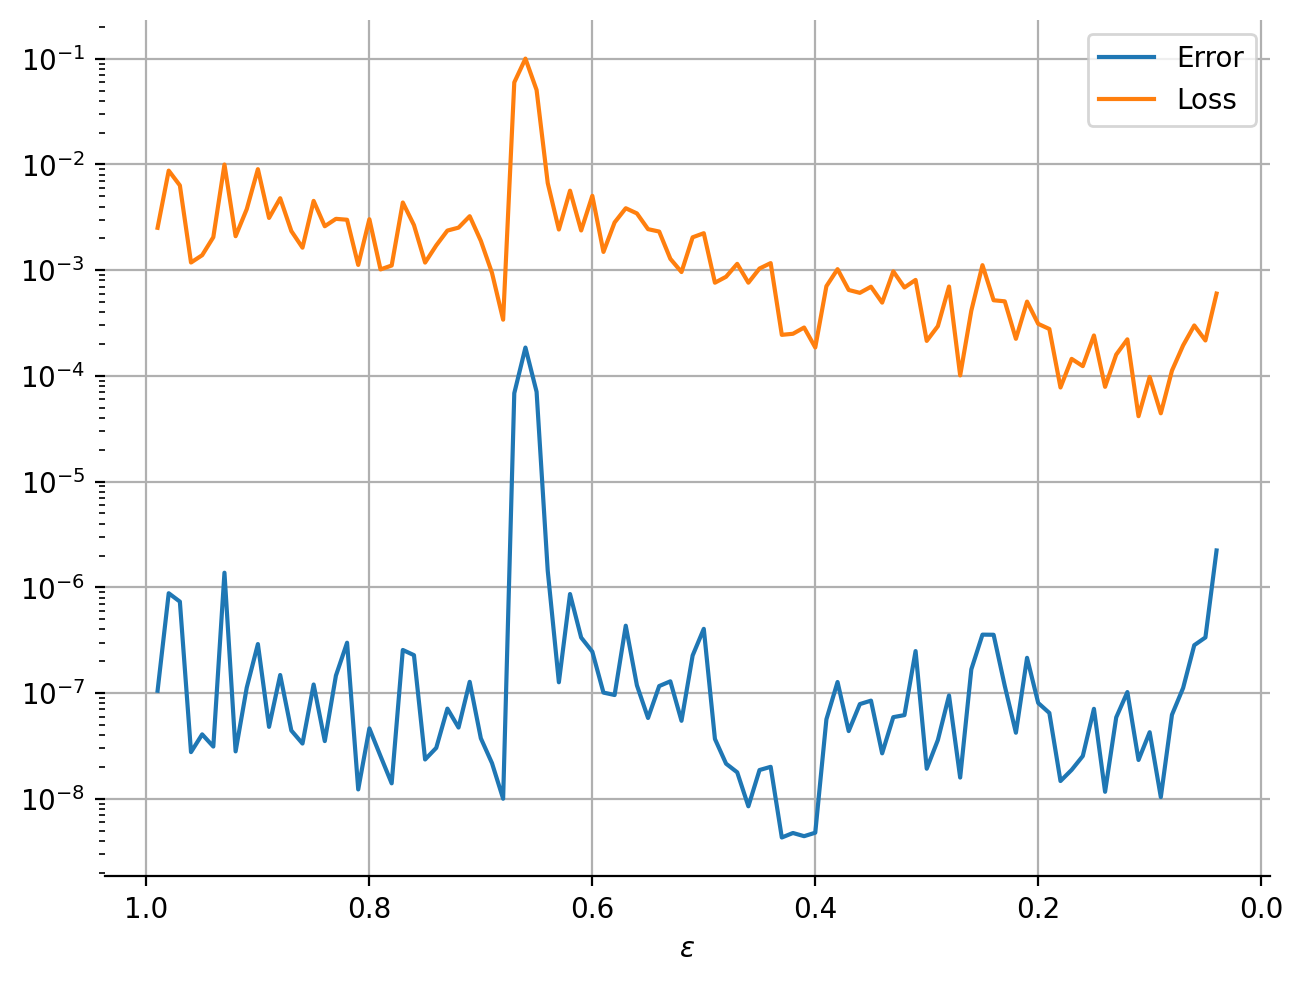

In [11]:
fig, ax = plt.subplots()
ax.plot(Eps, DATA91, c="C0", label="Error")
ax.plot(Eps, DATA92, c="C1", label="Loss")

ax.set(
    yscale="log",
    xlabel=r"$\epsilon$",
)
ax.grid()
ax.legend()
ax.invert_xaxis()
ax.spines[["top", "right", "left"]].set_visible(False)
pass